In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import datetime as dt
from datetime import datetime
import bz2
import pickle
import _pickle as cPickle

%matplotlib inline

In [376]:
tickers = pd.read_csv('ticker_lists/ndx.csv', header=None)

In [377]:
tickers = tickers[0].to_list()

In [440]:
tickers = ['DANSKE.CO', 'JYSK.CO', 'NDA-DK.CO']
stocks = download_tickers(tickers)

In [441]:
close = stocks.loc[:, stocks.columns.get_level_values(1).isin(['Adj Close'])]
close = close.dropna()

In [442]:
close.mean(axis=1)

Date
2004-10-04     97.031690
2004-10-05     96.426877
2004-10-06     96.111766
2004-10-07     95.789477
2004-10-08     95.061652
                 ...    
2020-08-31    111.160000
2020-09-01    109.083332
2020-09-02    109.140001
2020-09-03    109.990002
2020-09-04    109.743331
Length: 3979, dtype: float64

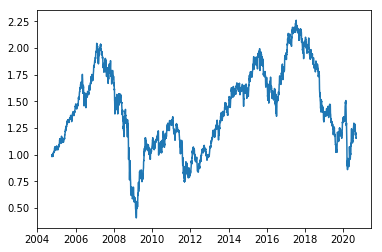

In [445]:
sns.lineplot(data=(close/close.iloc[0, :]).mean(axis=1))
#plt.plot(close[['SPY']/close[['SPY']].ialoc[0,:])
#plt.yscale('log')

In [ ]:
sns.lineplot(data=stocks.loc[:, stocks.columns.get_level_values(1).isin(['Volume'])]

In [425]:
def download_tickers(tickers):
    # Fetch downloaded ticker from raw_data
    downloaded_tickers = [x[0:-5] if '.pbz2' in x else '' for x in os.listdir('raw_data/')]
    downloaded_tickers.remove('')
    # Check if tickers already are downloaded
    tickers_to_download = []
    for ticker in tickers:
        if ticker in downloaded_tickers:
            # If already downloaded, check if they need updates
            if update_ticker(ticker):
                tickers_to_download.append(ticker)
        else:
            tickers_to_download.append(ticker)

    not_downloaded = download_dump(tickers_to_download)
    tickers_to_load = [x for x in tickers if x not in not_downloaded]
    # Read tickers from json and return
    return load_stocks(tickers_to_load)

In [426]:
def load_stocks(tickers):
    cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    index = pd.MultiIndex.from_product([tickers, cols], names=['Stock ticker', 'Data type'])
    if len(tickers) > 1:
        data = pd.concat([decompress_pickle('raw_data/' + x + '.pbz2') for x in tickers], axis=1, sort=True)
    else:
        data = decompress_pickle('raw_data/' + tickers[0] + '.pbz2')
    
    data.columns = index
    try:
        data.index = pd.to_datetime(data.index, unit='ms')
    except ValueError:
        data.index = pd.to_datetime(data.index)
    return data

In [427]:
def update_ticker(ticker):
    last_bday = last_weekday()
    newest_date = decompress_pickle('raw_data/' + ticker + '.pbz2').index[-1]
    if newest_date == float:
        newest_date = dt.datetime.fromtimestamp(newest_date/1000).date()
    if newest_date != last_bday:
        return True 
    else:
        return False

In [420]:
def download_dump(tickers):
    not_downloaded = []
    if tickers != []:
        data = yf.download(tickers, period='100y', group_by='tickers')
        if len(tickers) > 1:
            for ticker in tickers:
                    clean_data = clean_df(data[ticker])
                    if len(clean_data) > 1:
                        compressed_pickle(ticker, clean_data)
                    else:
                        not_downloaded.extend(tickers)
        else:
            clean_data = clean_df(data)
            if len(clean_data) > 1:
                compressed_pickle(tickers, clean_data)
            else:
                not_downloaded.extend(tickers)
                
    return not_downloaded 

In [421]:
def last_weekday():
    todays_day = dt.date.today().day
    if todays_day in [5, 6]:
        return dt.date.today() - dt.timedelta(days=todays_day-4)
    else:
        return dt.date.today()


In [422]:
def clean_df(df):
    df = df.dropna(axis = 0, how='all')
    return df

In [423]:
def compressed_pickle(ticker, data):
    ticker = ticker[0] if isinstance(ticker, list) else ticker
    with bz2.BZ2File('raw_data/' + ticker + '.pbz2', 'w') as f: 
        cPickle.dump(data, f)

In [424]:
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

In [ ]:
test = decompress_pickle('raw_data/Y.pbz2')

In [ ]:
test

In [ ]:
sns.lineplot(data=test['Adj Close'])

In [ ]:
import os

def clean_raw_files():
    for filename in os.listdir('raw_data'):
        if filename.endswith(".pbz2"): 
            df = pd.DataFrame(decompress_pickle('raw_data/' + filename))
            non_zeroes = len(df) - df.iloc[:, 4].isna().sum()
            if non_zeroes < 2:
                os.remove('raw_data/' + filename)
            else:
                df = df.dropna(how='all', axis=0)
                ticker = filename.replace('.pbz2', '')
                compressed_pickle(ticker, df)
                  
remove_empties()